In [1]:
using ReinforcementLearningAnIntroduction

using StatsBase

using Plots

In [2]:
true_values = [i/6 for i in 1:5]

5-element Array{Float64,1}:
 0.16666666666666666
 0.3333333333333333 
 0.5                
 0.6666666666666666 
 0.8333333333333334 

In [3]:
env = RandomWalkEnv(leftreward=0.)
n_state, n_action = length(get_observation_space(env)), length(get_action_space(env))

(7, 2)

In [4]:
struct RecordRMS <: AbstractHook
    rms::Vector{Float64}
    RecordRMS() = new([])
end

(f::RecordRMS)(::PostEpisodeStage, agent, env, obs) = push!(f.rms, sqrt(mean((agent.policy.learner.approximator.table[2:end - 1] - true_values).^2)))

In [5]:
create_TD_agent(α) = Agent(
    policy=VBasedPolicy(
        learner = TDLearner(
            approximator=TabularApproximator(fill(0.5, n_state)),
            optimizer=Descent(α),
            method=:SRS
        ),
        mapping = (obs, V) -> begin
            value = zeros(n_action)
            value[rand(1:n_action)] = 1.0
            value
        end
    ),
    trajectory=EpisodicCompactSARTSATrajectory()
)

create_MC_agent(α) = Agent(
    policy=VBasedPolicy(
        learner=MonteCarloLearner(
            approximator=TabularApproximator(fill(0.5, n_state)),
            α=α,
            kind=EVERY_VISIT
            ),
        mapping = (obs, V) -> begin
            value = zeros(n_action)
            value[rand(1:n_action)] = 1.0
            value
        end
        ),
    trajectory=EpisodicCompactSARTSATrajectory()
)

create_MC_agent (generic function with 1 method)

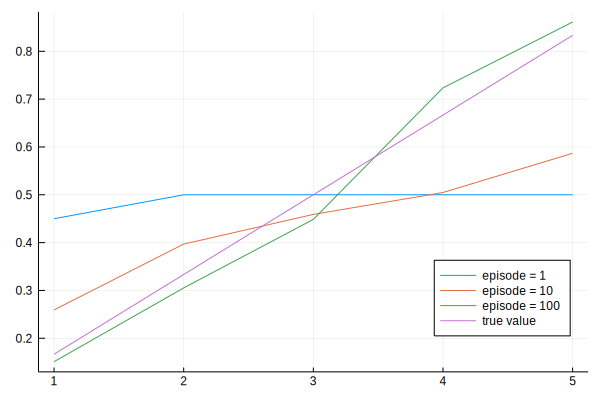

In [6]:
p = plot(;legend=:bottomright)
for i in [1, 10, 100]
    agent = create_TD_agent(0.1)
    run(agent, env, StopAfterEpisode(i))
    plot!(p, agent.policy.learner.approximator.table[2:end - 1], label="episode = $i")
end
plot!(p, true_values, label="true value")
p

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


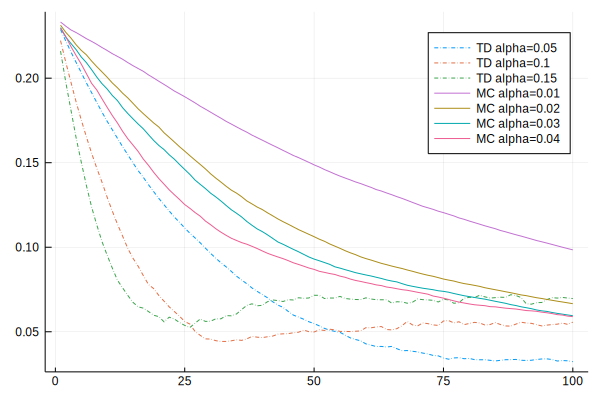

In [7]:
p = plot()

for α in [0.05, 0.1, 0.15]
    rms = []
    for _ in 1:100
        agent = create_TD_agent(α)
        hook = RecordRMS()
        run(agent, env, StopAfterEpisode(100),hook)
        push!(rms, hook.rms)
    end
    plot!(p, mean(rms), label ="TD alpha=$α", linestyle=:dashdot)
end

for α in [0.01, 0.02, 0.03, 0.04]
    rms = []
    for _ in 1:100
        agent = create_MC_agent(α)
        hook = RecordRMS()
        run(agent, env, StopAfterEpisode(100),hook)
        push!(rms, hook.rms)
    end
    plot!(p, mean(rms), label ="MC alpha=$α")
end

p

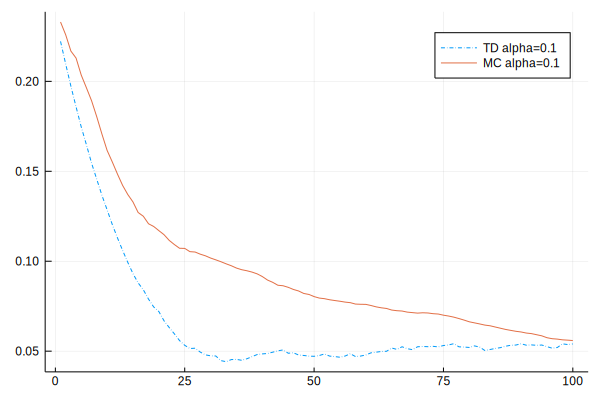

In [8]:
p = plot()

rms = []
for _ in 1:100
    agent = create_TD_agent(0.1)
    hook = RecordRMS()
    run(agent, env, StopAfterEpisode(100),hook)
    push!(rms, hook.rms)
end
plot!(p, mean(rms), label ="TD alpha=0.1", linestyle=:dashdot)


rms = []
for _ in 1:100
    agent = create_MC_agent(0.1)
    hook = RecordRMS()
    run(agent, env, StopAfterEpisode(100),hook)
    push!(rms, hook.rms)
end
plot!(p, mean(rms), label ="MC alpha=0.1")

p